## 构建图像输入管道

### 导入需要的包

In [1]:
import tensorflow as tf
import pathlib

In [2]:
print(tf.__version__)

2.0.0-alpha0


### 获取所有样本图片的路径

In [1]:
# 获取当前路径
data_root = pathlib.Path.cwd()
# 获取指定目录下的文件路径（返回是一个列表，每一个元素是一个PosixPath对象）
all_image_paths = list(data_root.glob('*/*/*'))
print(type(all_image_paths[0]))
# 将PosixPath对象转为字符串
all_image_paths = [str(path) for path in all_image_paths]
print(all_image_paths[0])
print(data_root)

NameError: name 'pathlib' is not defined

### 获取图片类标

In [73]:
# 获取图片类别的名称，即存放样本图片的五个文件夹的名称
label_names = sorted(item.name for item in data_root.glob('*/*/') if item.is_dir())
# 将类别名称转为数值型的类标
label_to_index = dict((name, index) for index, name in enumerate(label_names))
# 获取所有图片的类标
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print(label_to_index)
print("First 10 labels indices: ", all_image_labels[:2])
print("First 10 labels indices: ", all_image_paths[:2])

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
First 10 labels indices:  [1, 1]
First 10 labels indices:  ['/home/lqhou/workspace/TF_Book/Chapter2/tf_data/flower_photos/dandelion/14886963928_d4856f1eb6_n.jpg', '/home/lqhou/workspace/TF_Book/Chapter2/tf_data/flower_photos/dandelion/15549402199_2890918ddb.jpg']


### 加载和格式化图像数据

In [74]:
def load_and_preprocess_image(path):
    # 读取图片
    image = tf.io.read_file(path)
    # 将jpeg格式的图片解码，得到一个张量（三维的矩阵）
    image = tf.image.decode_jpeg(image, channels=3)
    # 由于数据集中每张图片的大小不一样，统一调整为192*192
    image = tf.image.resize(image, [192, 192])
    # 对每个像素点的RGB值做归一化处理
    image /= 255.0
    
    return image

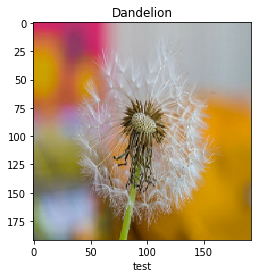

In [75]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel("test")
plt.title(label_names[label].title())
print()

### Build a tf.data.Dataset，A dataset of (image, label) pairs

In [76]:
# 构建图片路径的“dataset”
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
# 使用AUTOTUNE自动调节管道参数，
AUTOTUNE = tf.data.experimental.AUTOTUNE
# 构建图片数据的“dataset”
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
# 构建类标数据的“dataset”
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
# 将图片和类标压缩为（图片，类标）对
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

print(image_ds)
print(label_ds)
print(image_label_ds)

<ParallelMapDataset shapes: (192, 192, 3), types: tf.float32>
<TensorSliceDataset shapes: (), types: tf.int64>
<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


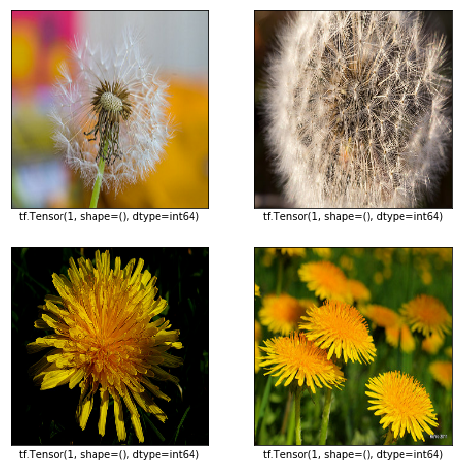

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image_label in enumerate(image_label_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image_label[0])
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(image_label[1])
plt.show()

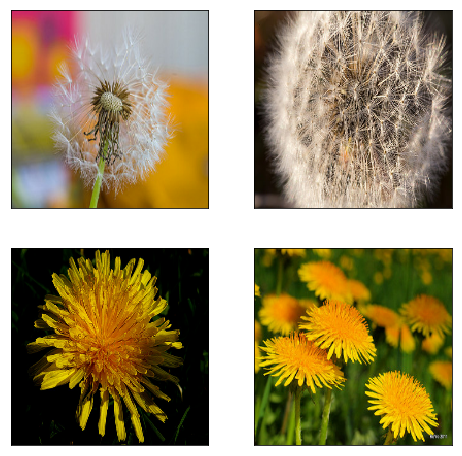

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("")

### Basic methods for training

In [79]:
# 下载的模型在用户根目录下“~/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_192_no_top.h5”
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3),
                                               include_top=False)
mobile_net.trainable = False

In [80]:
# 使用Dataset类的shuffle方法打乱数据集
image_count = len(all_image_paths)
ds = image_label_ds.shuffle(buffer_size=image_count)
# 让数据集重复多次
ds = ds.repeat()
# 设置每个batch的大小
BATCH_SIZE = 32
ds = ds.batch(BATCH_SIZE)
# 通过“prefetch”方法让模型的训练和每个batch数据集的加载并行
ds = ds.prefetch(buffer_size=AUTOTUNE)

In [81]:
# 定义一个函数用来将范围在[0,1]之间的数据映射到[-1,1]之间
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [82]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [88]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.0
max logit: 5.2331543

Shape: (32, 1280)


In [84]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [86]:
model.fit(ds, epochs=10, steps_per_epoch=500)

Epoch 1/10
500/500 [==============================] - 431s 862ms/step - loss: 1.4567 - accuracy: 0.6452
Epoch 2/10
500/500 [==============================] - 426s 851ms/step - loss: 1.4788 - accuracy: 0.7767
Epoch 3/10
500/500 [==============================] - 425s 850ms/step - loss: 1.5385 - accuracy: 0.7587
Epoch 4/10
500/500 [==============================] - 427s 854ms/step - loss: 1.5429 - accuracy: 0.7569
Epoch 5/10
500/500 [==============================] - 425s 849ms/step - loss: 1.5804 - accuracy: 0.7647
Epoch 6/10
500/500 [==============================] - 423s 846ms/step - loss: 1.5945 - accuracy: 0.7719
Epoch 7/10
500/500 [==============================] - 422s 843ms/step - loss: 1.6040 - accuracy: 0.7810
Epoch 8/10
500/500 [==============================] - 421s 842ms/step - loss: 1.6045 - accuracy: 0.7784
Epoch 9/10
500/500 [==============================] - 418s 836ms/step - loss: 1.6048 - accuracy: 0.7824
Epoch 10/10
500/500 [==============================] - 419s 838m